In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import os.path

df = pd.read_csv(f"../input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'])
df['quote_date']=pd.to_datetime(df['quote_date'])
df['delta'] = df['delta'].abs()

#Settings for backtest
min_delta = 0.019

In [2]:
df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['strike'] = 0
df_trades['delta'] = 0.0

In [3]:
# Create new filtered dataframe with only calls above target delta
df_calls = df[(df['type']=="C") & (df['delta']>= min_delta) & (df['quote_time'] == '15:45:00') & (df['dte'] > 0)]
# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
df_calls = df_calls.loc[df_calls.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
# Only keep the min expiration date for each quote
df_calls = df_calls.loc[df_calls.groupby('quote_date')[['dte']].idxmin()['dte']]
df_calls.head()

,expiration,strike,type,close,bid,ask,price,delta,theta,quote_date,quote_time,dte
1256,2022-01-05,4860.0,C,0.00,0.30,0.35,4787.43,0.0239,-0.3250,2022-01-03,15:45:00,2
2760,2022-01-05,4860.0,C,0.22,0.20,0.25,4801.64,0.0213,-0.2251,2022-01-04,15:45:00,1
4900,2022-01-07,4835.0,C,0.37,0.35,0.45,4720.41,0.0198,-0.3998,2022-01-05,15:45:00,2
5728,2022-01-07,4790.0,C,0.32,0.25,0.35,4699.72,0.0190,-0.3000,2022-01-06,15:45:00,1
8688,2022-01-10,4770.0,C,0.00,0.30,0.35,4684.28,0.0212,-0.3492,2022-01-07,15:45:00,1


In [4]:
# Create new filtered dataframe with only puts above target delta
df['delta'] = df['delta'].abs()
df_puts = df[(df['type']=="P") & (df['delta']>= min_delta) & (df['quote_time'] == '15:45:00') & (df['dte'] > 0)]
# We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
df_puts = df_puts.loc[df_puts.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
# Now that we're certain we have the minimum expiration date, get the minimum delta
df_puts = df_puts.loc[df_puts.groupby('quote_date')[['dte']].idxmin()['dte']]
df_puts.head()

,expiration,strike,type,close,bid,ask,price,delta,theta,quote_date,quote_time,dte
1098,2022-01-05,4660.0,P,0.00,0.40,0.50,4787.43,0.0195,-0.4495,2022-01-03,15:45:00,2
2642,2022-01-05,4710.0,P,0.37,0.35,0.40,4801.64,0.0219,-0.3750,2022-01-04,15:45:00,1
4662,2022-01-07,4535.0,P,0.00,0.65,0.75,4720.41,0.0204,-0.7000,2022-01-05,15:45:00,2
5558,2022-01-07,4575.0,P,0.00,0.40,0.50,4699.72,0.0199,-0.4500,2022-01-06,15:45:00,1
8522,2022-01-10,4560.0,P,0.45,0.40,0.55,4684.28,0.0207,-0.5089,2022-01-07,15:45:00,1


In [5]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
       return pd.Series([0,0,0])
    return pd.Series([df1['strike'],df1['delta'],price])


def get_amount_lost(contract_date, strike, option_type):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['strike']==strike) & (df['type']==option_type) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    if option_type == 'P':
        diff = strike - underlying
    else:
        diff = underlying - strike
    if diff > 0.0:
        return diff*100
    return 0      

In [6]:
#Need to figure out how to extract strike, delta, and the average between bid/ask from one "apply" operation
df_trades['strike'],df_trades['delta'],df_trades['collected'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_calls), axis = 1).T.values
df_trades['lost'] = df_trades.apply(lambda row : get_amount_lost(row['expiration'], row['strike'], 'C'), axis=1)
df_trades['net'] = df_trades['collected'] - df_trades['lost']


In [7]:
df_trades['net'] = df_trades['collected'] - df_trades['lost']

# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [8]:
df_trades.tail(40)

,expiration,trade_date,collected,lost,strike,delta,net
72,2022-06-01,2022-05-31,45.0,0.00,4260.0,0.0215,45.00
73,2022-06-02,2022-06-01,65.0,0.00,4225.0,0.0307,65.00
74,2022-06-03,2022-06-02,35.0,0.00,4270.0,0.0191,35.00
75,2022-06-06,2022-06-03,45.0,0.00,4225.0,0.0211,45.00
76,2022-06-07,2022-06-06,37.5,0.00,4225.0,0.0204,37.50
77,2022-06-08,2022-06-07,37.5,0.00,4250.0,0.0225,37.50
78,2022-06-09,2022-06-08,35.0,0.00,4225.0,0.0196,35.00
79,2022-06-10,2022-06-09,55.0,0.00,4205.0,0.0192,55.00
80,2022-06-13,2022-06-10,55.0,0.00,4070.0,0.0211,55.00
81,2022-06-14,2022-06-13,65.0,0.00,3930.0,0.0200,65.00


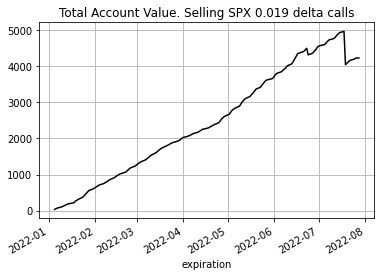

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
df_trade_plot.plot(ax=ax, style='k-')
plt.title(f"Total Account Value. Selling SPX {min_delta} delta calls")
plt.grid()
plt.savefig(f"{min_delta}.png")